<a href="https://colab.research.google.com/github/djbell01/563-DawsonBell/blob/main/Week_3_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo

In [32]:
import numpy as np
import matplotlib.pyplot as plt

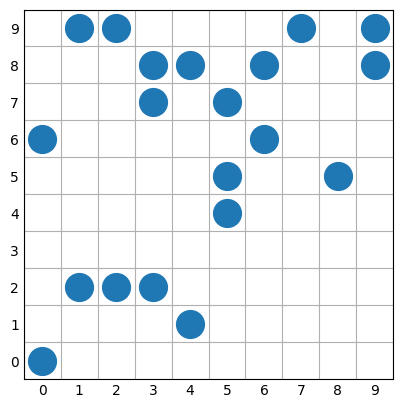

In [161]:
import numpy as np
import matplotlib.pyplot as plt

# Particle class
class particle():
    def __init__(self, x, y):
        self.x = x
        self.y = y

# Grid class
class grid():
    def __init__(self, length, N):
        # Initialize grid dimensions and RNG
        self.length = length
        self.N = N
        self.rng = np.random.default_rng()

        # Track occupied positions
        self.occupied_positions = set()
        self.particles = []

        # Generate random positions for N particles without overlap
        while len(self.particles) < N:
            x = self.rng.integers(0, length)
            y = self.rng.integers(0, length)
            if (x, y) not in self.occupied_positions:
                self.particles.append(particle(x, y))
                self.occupied_positions.add((x, y))

    def move_particle(self, index):
        # Determine empty spaces
        empty_spaces = [
            (i, j)
            for i in range(self.length)
            for j in range(self.length)
            if (i, j) not in self.occupied_positions
        ]

        # Choose a random empty space
        rand_empty_space = empty_spaces[self.rng.integers(0, len(empty_spaces))]

        # Update particle's position and occupied positions
        old_position = (self.particles[index].x, self.particles[index].y)
        self.occupied_positions.remove(old_position)
        self.particles[index].x, self.particles[index].y = rand_empty_space
        self.occupied_positions.add(rand_empty_space)

  # Visualize grid for debugging
    def plot_grid(self):
      fig = plt.figure()
      ax = fig.add_subplot(1, 1, 1)

      # Define gridlines that align correctly
      gridlines = np.arange(0, self.length + 1)  # Include 0 to max_value + 1

      # Set major ticks at integer values
      ax.set_xticks(gridlines)
      ax.set_yticks(gridlines)

      # Set minor ticks in between
      minor_ticks = gridlines - 0.5
      ax.set_xticks(minor_ticks, minor=True)
      ax.set_yticks(minor_ticks, minor=True)

      # Add grid lines for minor ticks
      ax.grid(which='minor')

      # Turn off tick labels
      ax.tick_params(axis='both', which='both', length=0)

      # Plot the point
      x_vals = [p.x for p in self.particles]
      y_vals = [p.y for p in self.particles]
      ax.scatter(x_vals, y_vals, 400)

      # Set bounds and aspect ratio
      ax.set_xlim(-0.5, self.length - 0.5)
      ax.set_ylim(-0.5, self.length - 0.5)
      ax.set_aspect('equal', adjustable='box')

    def calculate_energy(self):
      for i in range(self.N):
        # Define neighboring spaces
        up = [self.particles[i].x,self.particles[i].y + 1]
        down = [self.particles[i].x,self.particles[i].y - 1]
        left = [self.particles[i].x - 1,self.particles[i].y]
        right = [self.particles[i].x + 1,self.particles[i].y]
        # Account for periodic boundary conditions
        if (up[0] == self.length) and (up[1] == self.length):
          up = [0,0]
        elif (up[0] == -1) and (up[1] == -1):
          up = [self.length - 1,self.length - 1]



grid_instance = grid(10, 20)
grid_instance.plot_grid()
